# Marimekko from Excel

This notebook is transforming an excel market share table for products in a marimekko graphic (aka mosaic graphic).

According to [Wikipedia](https://en.wikipedia.org/wiki/Marimekko#Marimekko_chart)

The Marimekko name has been adopted within business and the management consultancy industry to refer to a specific type of bar chart known as a variable-width chart or Mosaic plot in which all the bars are of equal height, there are no spaces between the bars, and the bars are in turn each divided into segments of different width. The design of the mosaic plot resembles a Marimekko print. The chart's design encodes two variables (such as percentage of sales and market share), but it is criticised for making the data hard to perceive and to compare visually. The Marimekko has a sister chart called the Bar Mekko in which the bars are of variable height and width.

Depending on the input data format, some tweaks might be needed.
The process described here is for an excel file providing market absolute values per competitor and per product lines.

**The data used in this example is fake**

## Loading Libraries

pandas version must be latter than 0.20.0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import (TextArea, AnnotationBbox)

In [2]:
print (pd.__version__)

0.25.0


# Preparing data

## Reading the excel spreadsheet
- Format: a simple table where first column is Competitor Name and next columns are Products Revenues
- First row is column headings

In [3]:
# the file named "data.xlsx" is expected to be uploaded in the notebook directory
# make the appropriate changes if this is not the case
df = pd.read_excel("data.xlsx")

In [4]:
df.head()

,Competitor,01- DCS,03-2 PLC,04- C&S + Safety,02-2 Drives LV,02-1 Motor Starters & Contactors,02-3 Motion,03-3 CNC,01- Control Valves,04- Sensors,01- Instruments,03-1 OP & IPC,01- Analyzers,02-2 Drives MV,01- Safety Systems,03-3 Vision
0,Turck,2096.655000,3479.765140,739.597707,1306.214286,1732.807500,626.370000,2105,88.000000,53.84955,255.961458,761.595000,75.325850,300.360220,144.100000,12
1,Heidenhain,896.071605,1042.708610,525.315341,576.744149,1747.106782,264.824194,0,20.000000,128.10957,88.950000,315.365346,17.000000,139.215120,434.214000,0
2,M-System,2647.188914,244.125339,334.542964,1937.182431,1366.234254,36.206895,0,22.520548,0.00000,363.340000,17.395233,125.937107,549.145320,209.210000,0
3,Hyosung Power and Industrial S,427.504641,2792.306143,595.818740,1117.427569,645.193950,575.100000,0,0.000000,96.87260,0.000000,306.571934,0.000000,364.111764,221.253389,0
4,Yokogawa,0.000000,472.400464,38.043350,0.000000,0.000000,152.727647,0,0.000000,0.00000,0.000000,222.148005,0.000000,0.000000,0.000000,0


## Reorganize the table as a list
- Unpivot table
- suppress zero values

In [5]:
dfu = df.melt(id_vars=['Competitor'],var_name='Product',value_name='Share')

In [6]:
dfu=dfu[dfu['Share']!=0]

In [7]:
dfu.head()

,Competitor,Product,Share
0,Turck,01- DCS,2096.655000
1,Heidenhain,01- DCS,896.071605
2,M-System,01- DCS,2647.188914
3,Hyosung Power and Industrial S,01- DCS,427.504641
6,Omron,01- DCS,1497.408000


## Create the markets dataFrame
- the Share column is the total value
- the Product is the index
- pMarkets is the relative size dataFrame of the market in ascending order
- pMarkets sum of all Share is 1
- pMarkets Share represent the % of Marimekko height

In [8]:
markets = dfu.groupby('Product').sum()

In [9]:
markets.head()

,Share
Product,
01- Analyzers,3742.423560
01- Control Valves,6391.204153
01- DCS,13521.007658
01- Instruments,5588.124370
01- Safety Systems,2371.702321


In [10]:
smarkets = markets.sort_values(by=['Share'],ascending=True)
marketsize = smarkets.sum()
pMarkets = smarkets/ marketsize

In [11]:
marketsize

Share    104991.775071
dtype: float64

- pMarket holds the relative size \[0,1\] of a given market 
- marketsize is the total market value = sum of all cells

In [12]:
pMarkets.head()

,Share
Product,
03-3 Vision,0.017744
01- Safety Systems,0.022589
02-2 Drives MV,0.027035
01- Analyzers,0.035645
03-1 OP & IPC,0.042742


## Create and process the "Competitor", "Product" classification Dataframe

In [13]:
cp= dfu.groupby(['Competitor','Product']).agg({'Share': 'sum'})

In [14]:
cp.head()

Share
Competitor Product                                      
ABB        02-1 Motor Starters & Contactors   415.130598
           02-2 Drives LV                     600.815056
           02-3 Motion                        688.874676
           03-1 OP & IPC                      218.548738
           03-2 PLC                          1237.675319

Transform into relative data \[0,1\] into the cpp dataFrame

In [15]:
# level=1 means grouping according to products
cpp = cp.groupby(level=1).apply(lambda x: x / float(x.sum()))

## Overview of some results

In [16]:
# Market Shares of ABB
cpp.loc['ABB',:]

,Share
Product,
02-1 Motor Starters & Contactors,0.043126
02-2 Drives LV,0.055345
02-3 Motion,0.096426
03-1 OP & IPC,0.048701
03-2 PLC,0.097521
03-3 CNC,0.145020
04- C&S + Safety,0.008487
04- Sensors,0.000392


In [17]:
# Market Share of ABB for 02-1 Motor Starters & Contactors
float(cpp.loc[('ABB','02-1 Motor Starters & Contactors'),:])

0.0431259130916086

### classification by "Product" "Competitor"

In [18]:
ppc = cpp.swaplevel(0,1).sort_index()

In [19]:
ppc.head()

Share
Product       Competitor                               
01- Analyzers CCI                              0.027391
              Contec                           0.010073
              FANUC                            0.009594
              Flowserve Flow Control Division  0.014429
              Heidenhain                       0.004543

What are the competitors market shares for the 02-1 Motor Starters & Contactors market?

In [20]:
ppc.loc['02-1 Motor Starters & Contactors']

,Share
Competitor,
ABB,0.043126
Banner,0.010595
DKK-TOA Corporation,0.005435
Danaher Industrial,0.003013
Festo,0.004544
Fuji Electric,0.007533
Heidenhain,0.181498
Hitachi,0.026385
Hyosung Power and Industrial S,0.067026


# Making the graphic

## Using matplotlib graphing package

In [21]:
def marimekko(ssmarkets,ccsss,lowshare,drawshare,marketshare,height,width,showther,marketsize):
    x=0
    y=0
    print(f"{float(marketsize):,.0f}")
    fig,ax = plt.subplots(1,figsize=(width,height))
    ax.axis([0, 1, 0, 1])
    ax.axis('off')
    marketcount=0

    for market in ssmarkets.index:
        h = float(ssmarkets.loc[market])
        #print(f"height'{market}':{h:.0f}")
        competitors = ccsss.loc[market].sort_values(by=['Share'],ascending=False)
        x=0
        other = 0.0
        count=0
        first = True
        ccompetitor=0
        for competitor in competitors.index:
            if ccompetitor == 0:
                marketboxtext = TextArea(f"{market} ({h*100:.0f}%)", minimumdescent=False)
                ab = AnnotationBbox(marketboxtext, (x,y),
                                    xybox=(x,y),
                                    box_alignment=(0., -0.2))
                ax.add_artist(ab)
            if competitor != 'Other':
                w = float(ccsss.loc[market].loc[competitor])
                if (w >=lowshare):
                    #print(f"  width {competitor}:{w:.0f}")
                    #print(f"({w},{h})")
                    if marketcount > 0: #< (len(ssmarkets.index)-1):
                        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='k',facecolor='none')
                    else:
                        rect = patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='k',facecolor='none')
                    ax.add_patch(rect)
                    rx, ry = rect.get_xy()
                    cx = rx + rect.get_width()/2.0
                    cy = ry + rect.get_height()/2.0
                    if h>=marketshare:
                        if w<=drawshare:
                            if first:
                                if ccompetitor==0:
                                    count=0
                                else:
                                    count=1
                                first=False                    
                            if count % 2 == 1:
                                ax.annotate(f"{competitor}", (rx+0.005, ry+rect.get_height()*0.9), fontsize=8, ha='left', va='top')
                            else:
                                ax.annotate(f"{competitor}", (rx+0.005, ry+rect.get_height()*0.2), fontsize=8, ha='left', va='top')
                            count += 1                    
                        else:        
                            ax.annotate(f"{competitor}", (rx+0.005, ry+rect.get_height()*0.9), fontsize=8, ha='left', va='top')
                        ax.annotate(f"{w*100:.0f}%", (cx, cy), weight='bold', fontsize=8, ha='center', va='center')
                    x += w
                else:
                    other += w
            else:
                other += float(ccsss.loc[market].loc['Other'])
            ccompetitor +=1
                
        #print(x,y)
        if marketcount > 0:
            rect = patches.Rectangle((x,y),other-0.001,h,linewidth=1,edgecolor='k',facecolor='none')
        else:
            rect = patches.Rectangle((x,y),other,h,linewidth=2,edgecolor='k',facecolor='none')
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        if h>=marketshare:
            if first:
                count=0
                first = False
            if showther:
                if count % 2 == 1:
                    ax.annotate(f"Others", (rx+rect.get_width()/1.2, ry+rect.get_height()*0.9), fontsize=8, ha='left', va='top')
                else:
                    ax.annotate(f"Others", (rx+rect.get_width()/1.2, ry+rect.get_height()*0.2), fontsize=8, ha='left', va='top')
            ax.annotate(f"{other*100:.0f}%", (cx, cy), weight='bold', fontsize=8, ha='center', va='center')
        y += h
        marketcount += 1

    plt.show()

104,992


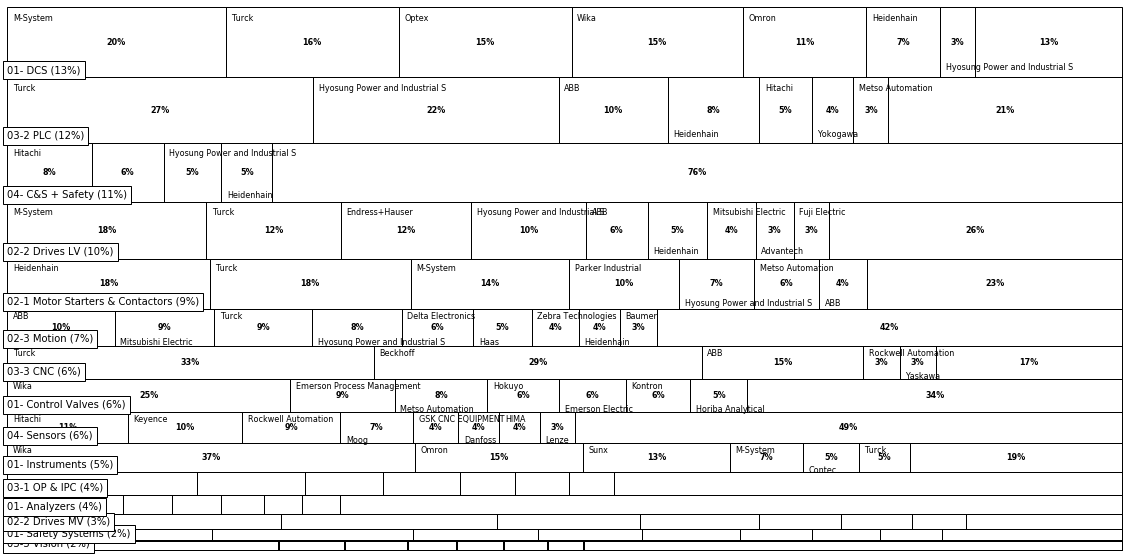

In [22]:
height = 10
width = 20
lowshare = 0.03
drawshare = 0.1
marketshare=0.05
showther=False
marimekko(pMarkets,ppc,lowshare,drawshare,marketshare,height,width,showther,marketsize)

## Using python-pptx

Python-pptx is a library allowing to generate Microsoft PowerPoint compatible files.

The library documentation is [here](https://python-pptx.readthedocs.io/en/latest/index.html)

This library is not necessarly installed, using the cell after next cell command, one can install it if not done already
To check if installed and version, just try next cell command.

If not installed, don't forget to load it after install

In [23]:
import pptx
print(pptx.__version__)

0.6.18


In [24]:
!conda install -y python-pptx

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [25]:
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE
from pptx.util import Inches
from pptx.enum.text import MSO_AUTO_SIZE
from pptx.util import Pt
from pptx.dml.color import RGBColor
from pptx.enum.dml import MSO_THEME_COLOR

In [26]:
def rectangle(shapes,offset,sx,sy,sw,sh,text):
    #print(f"x:{sx:.2f}|y:{sy-sh:.2f}|w:{sw:.2f}|h:{sh:.2f}")
    isx = Inches((sx+offset)/2.54)
    isy = Inches((sy-sh)/2.54)
    isw = Inches(sw/2.54)
    ish = Inches(sh/2.54)
    # isx,isy is the top left corner of the rectangle
    shape = shapes.add_shape(MSO_SHAPE.RECTANGLE,isx,isy,isw,ish)
    shape.fill.background()
    text_frame = shape.text_frame
    text_frame.margin_left=Inches(0.0) 
    text_frame.margin_right=Inches(0.0) 
    text_frame.margin_top=Inches(0.0)
    text_frame.margin_bottom=Inches(0.0)
    text_frame.word_wrap = True
    text_frame.auto_size = MSO_AUTO_SIZE.TEXT_TO_FIT_SHAPE                
    p = text_frame.paragraphs[0]
    run = p.add_run()
    run.text = text
    font = run.font
    font.name = 'Calibri'
    font.size = Pt(8)
    font.bold = True
    font.italic = None  # cause value to be inherited from theme
    font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
    return (run,font)
    
def marimekkopptx(ssmarkets,ccsss,lowshare,drawshare,marketshare,height,width,showther,marketsize):
    prs = Presentation()
    title_only_slide_layout = prs.slide_layouts[5]
    slide = prs.slides.add_slide(title_only_slide_layout)
    shapes = slide.shapes

    shapes.title.text = f"Market Size = {float(marketsize):,.0f}"
    
    x0 = 1.0
    y0 = 17.0
    owidth = 3.0

    x=0
    y=0
    marketcount=0

    for market in ssmarkets.index:
        h = float(ssmarkets.loc[market])
        #print(f"height'{market}':{h:.0f}")
        competitors = ccsss.loc[market].sort_values(by=['Share'],ascending=False)
        x=0
        other = 0.0
        count=0
        first = True
        ccompetitor=0
        for competitor in competitors.index:
            if ccompetitor == 0:
                # print market label
                sx = (x*width+x0)
                sy = (y0-(y*height))
                sw = owidth
                sh = (h*height)
                run,font = rectangle(shapes,0,sx,sy,sw,sh,f"{market} ({h*100:.0f}%)")
            if competitor != 'Other':
                w = float(ccsss.loc[market].loc[competitor])
                if (w >=lowshare):
                    #print(f"  width {competitor}:{w:.0f}")
                    #print(f"({w},{h})")
                    # create the rectangle
                    sx = (x*width+x0)
                    sy = (y0-(y*height))
                    sw = (w*width)
                    sh = (h*height)
                    run,font = rectangle(shapes,owidth,sx,sy,sw,sh,"")
                    if w<=drawshare:
                        run.text = f"{competitor[:5]} ({w*100:.0f}%)"
                        if h >= marketshare:
                            font.size = Pt(6)
                        else:
                            font.size = Pt(4)
                    else:
                        run.text = f"{competitor} ({w*100:.0f}%)"
                        if h >= marketshare:
                            font.size = Pt(8)
                        else:
                            font.size = Pt(6)
                    x += w
                else:
                    other += w
            else:
                other += float(ccsss.loc[market].loc['Other'])
            ccompetitor +=1
                
        #print(x,y)
        w=other
        sx = (x*width+x0)
        sy = (y0-(y*height))
        sw = (w*width)
        sh = (h*height)
        run,font = rectangle(shapes,owidth,sx,sy,sw,sh,"")
        if w<=drawshare:
            run.text = f"({w*100:.0f}%)"
            if h >= marketshare:
                font.size = Pt(6)
            else:
                font.size = Pt(4)
        else:
            run.text = f"({w*100:.0f}%)"
            if h >= marketshare:
                font.size = Pt(8)
            else:
                font.size = Pt(6)
        y += h
        marketcount += 1

    return prs

## Just call the marimekkopptx function to create a Powerpoint Slide with
- height = the height of the marimekko area in cm
- width = the width of the marimekko area in cm
- lowshare = in % (1% = 0.01) under this share no competitor is shown
- drawshare = in % bellow this share, the font is getting smaller
- marketshare = in % if a market is less than marketshare of total market, font is getting smaller

You can change the name and location of the output file (PowerPoint compatible). use your local PowerPoint software application to read the file after downloading it to your computer.

In [27]:
height = 12.0
width = 20.0
lowshare = 0.03
drawshare = 0.1
marketshare=0.05
showther=False
prs = marimekkopptx(pMarkets,ppc,lowshare,drawshare,marketshare,height,width,showther,marketsize)
prs.save("marimekko.pptx")